# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import time
import random
import numpy as np

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('A37_example_test') # dataset directory
schema_path = os.path.join('data', dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

In [3]:
# Set up base parameters of system.
ids = [5,11,14,16,24,29]

base_kwargs = {
    'output_dir_path': os.path.join('data','A37_example_test'),
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': [3127.0,2736.0,2746.0,2448.0,4788.0,4565.0], # from Annex 37
    'battery_power_capacities': [391.0,342.0,343.0,306.0,598.0,571.0], # from Annex 37
    'battery_efficiencies': None,
    'pv_power_capacities': [178.0,41.0,57.0,120.0,1349.0,257.0], # from Annex 37
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [4]:
# Set up probabilistic model of effiencies and take draws
n_draws = 10 #1000
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

array([[0.89141181, 0.90184601, 0.7476298 , 0.8941517 , 0.8461359 ,
        0.82799709],
       [0.79726134, 0.80805207, 0.77308617, 1.        , 0.71274366,
        0.743611  ],
       [0.85355032, 0.89296702, 0.9187231 , 1.        , 0.78207641,
        0.9248155 ],
       [0.93467796, 0.8258746 , 0.84398388, 0.84864486, 0.72359315,
        0.86024879],
       [0.91022908, 0.86212253, 0.72817075, 0.90299636, 0.96847968,
        0.75541582],
       [0.96294672, 0.94240722, 0.9395038 , 0.70254068, 0.78701172,
        0.83168255],
       [0.71571095, 0.96774555, 0.81309531, 0.79598975, 0.71594318,
        0.85131743],
       [0.98614507, 0.65188657, 0.75872406, 0.93303198, 0.72783706,
        1.        ],
       [1.        , 0.83215041, 1.        , 0.80528113, 0.8314814 ,
        0.87629888],
       [0.83972714, 0.95066624, 0.81165159, 0.8291535 , 1.        ,
        0.87380232]])

In [5]:
#num_scenarios = [1,2,3,5,8,10,15,20]
num_scenarios = [1,2]
runtimes = {}

for M in num_scenarios:
    print(f"# Scenarios: {M}")

    envs = []

    etas = [eta_samples[k] for k in range(M)] # get M samples

    for m in range(M):
        # Build schema.
        base_kwargs.update({
                'battery_efficiencies': etas[m]
            })
        schema_path = build_schema(**base_kwargs)

        # Initialise CityLearn environment object.
        envs.append(CityLearnEnv(schema=schema_path))

        if m == 0: # initialise lp object
            lp = LinProgModel(env=envs[m])
        else:
            lp.add_env(env=envs[m])

    lp.set_time_data_from_envs()
    lp.generate_LP(clip_level='b',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
    lp.set_LP_parameters()

    start = time.time()
    lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
    end = time.time()

    print(lp_results['battery_capacities'],lp_results['solar_capacities'])

    runtimes.update({M: end-start})
    print(f"Solve time: {round(runtimes[M],1)}s")

# Scenarios: 1
[[0.89141181 0.90184601 0.7476298  0.8941517  0.8461359  0.82799709]]
[1104.86872077  918.09393886  822.66499527  702.87436092 2014.44473945
 1649.33325797] [ 782.13179333  651.06486262  655.6982988   582.5626912  1306.32435678
 1120.38541242]
Solve time: 34.6s
# Scenarios: 2
[[0.89141181 0.90184601 0.7476298  0.8941517  0.8461359  0.82799709]
 [0.79726134 0.80805207 0.77308617 1.00938276 0.71274366 0.743611  ]]
[1100.44790508  924.3227876   823.13533015  733.64611626 2025.25917786
 1655.2882271 ] [ 786.85446009  655.22226376  654.39484425  579.65487775 1315.29910163
 1125.57407463]
Solve time: 155.0s


In [6]:
# Fit linear trend to log(runtime)
trend = np.polyfit(np.log(list(runtimes.keys())),np.log(list(runtimes.values())),deg=1)
print(trend)

[2.16272606 3.54417987]


In [7]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trend[1])/trend[0])
print(scenarios_limit)

78.34820500464524


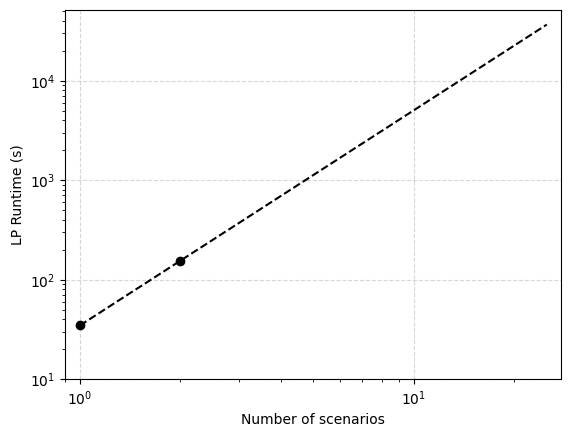

In [8]:
# Plot computational time results
max_scenarios = 25

plt.plot(runtimes.keys(),runtimes.values(),'ok')
plt.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trend[0] + trend[1]),'k--')
plt.xlabel("Number of scenarios")
plt.xscale('log')
plt.ylabel('LP Runtime (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(10)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.show()

In [9]:
# Compute MC estimate of true system cost

base_kwargs.update({ # set system to best scenario optimised design (latest)
    'battery_energy_capacities': lp_results['battery_capacities'],
    'pv_power_capacities': lp_results['solar_capacities']
})

cost_evals = []

# TODO: add multiprocessing to speed up
# add tqdm supress flag, use disable=True kwarg
# need to build schemas programmatically and then clean up

for j in range(n_draws):

    etas = eta_samples[j]

    # Build schema.
    base_kwargs.update({
            'battery_efficiencies': etas
        })
    schema_path = build_schema(**base_kwargs)

    eval_results = evaluate_system(schema_path,pricing_dict,opex_factor)

    cost_evals.append(eval_results['objective'])

17600it [01:28, 198.76it/s]                           


Evaluation complete.


17600it [01:29, 195.73it/s]                           


Evaluation complete.


17600it [01:27, 201.33it/s]                           


Evaluation complete.


17600it [01:29, 196.74it/s]                           


Evaluation complete.


17600it [01:29, 197.35it/s]                           


Evaluation complete.


17600it [01:29, 196.29it/s]                           


Evaluation complete.


17600it [01:30, 194.07it/s]                           


Evaluation complete.


17600it [01:28, 198.65it/s]                           


Evaluation complete.


17600it [01:27, 201.59it/s]                           


Evaluation complete.


17600it [01:25, 205.99it/s]                           

Evaluation complete.


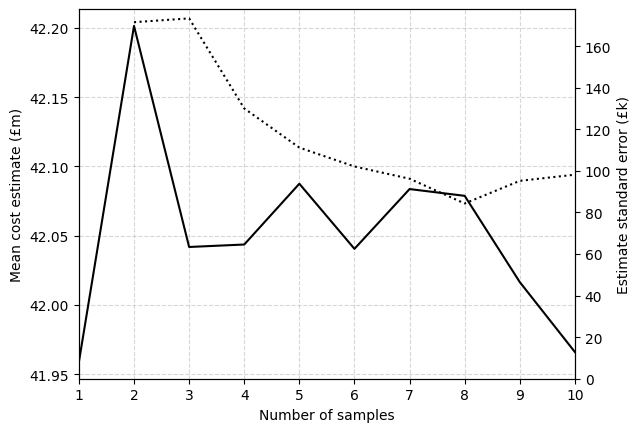

In [10]:
# Plot convergence of MC estimate
MC_means = [np.mean(cost_evals[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_evals[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)


plt.show()

To find a reasonable value of MC estimates needed we could repeat this analysis for a number of seeds and find the average number of samples needed for the standard error to fall below a given threshold, e.g. £100k, are initially peaking

In [11]:
print(cost_evals)
print(MC_means)
print(MC_stnd_errors)

[41958895.41047171, 42444021.47119994, 41722705.96174024, 42048985.12790314, 42263105.74272974, 41805466.980125204, 42342647.9112427, 42044515.12438793, 41518342.78897077, 41511639.34978167]
[41958895.41047171, 42201458.44083582, 42041874.281137295, 42043651.99282876, 42087542.74280895, 42040530.11569499, 42083689.80077324, 42078792.96622507, 42016520.724307925, 41966032.58685531]
[171517.96363562398, 173357.77762219423, 130027.4477430753, 111183.11982342156, 102109.38668713396, 96212.30988114931, 84310.29402431067, 95201.56365984895, 98160.32995537836]
